# Preprocess Event Logs for Process Prediction (Process Mining)

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tqdm
pd.options.display.max_columns= None
if "src" in os.getcwd():
    os.chdir("../")

## Configure

In [3]:
class EventLog:
    def __init__(self, file_path, kpi, dataset):
        self.file_path = file_path
        self.kpi = kpi
        self.dataset = dataset
        # === read file to get the dataframe
        if dataset == "completed.csv":
            self.df = pd.read_csv(self.file_path)
            self.df[start_date_name] = pd.to_numeric( self.df[start_date_name] ) // 1_000  # Convert Epochs from milliseconds to seconds
            self.df[end_date_name] = pd.to_numeric( self.df[end_date_name] ) // 1_000  # Convert Epochs from milliseconds to seconds

In [4]:
# Select the dataset to use
# data_file_path = "./data/VINST_cases_incidents_mini.csv"
# data_file_path = "./data/VINST cases incidents.csv"
dataset = "VINST cases incidents.csv"  # VINST case incident, for Total Time KPI case
# dataset = "completed.csv"                # bank_account_closure

In [5]:
data_dir = "./data"
data_file_path = os.path.join(data_dir, dataset)
if dataset == "completed.csv":
    KPI = "activity_occurrence"
    case_id_name = "REQUEST_ID"
    start_date_name = "START_DATE"
    activity_column_name = "ACTIVITY"
    end_date_name = "END_DATE"
    activity_to_avoid = "Back-Office Adjustment Requested"
    df = pd.read_csv(data_file_path)  # concern: what is date col position is different?
    df[start_date_name] = pd.to_numeric( df[start_date_name] ) // 1_000  # Convert Epochs from milliseconds to seconds
    df[end_date_name] = pd.to_numeric( df[end_date_name] ) // 1_000  # Convert Epochs from milliseconds to seconds

else:
    KPI = "total_time"
    case_id_name = 'SR_Number'  # The case identifier column name.
    start_date_name = 'Change_Date+Time'  # Maybe change to start_et (start even time)
    activity_column_name = "ACTIVITY"
    end_date_name = None
    train_size = 0.8
    df = pd.read_csv(data_file_path, parse_dates=[1])  # concern: what is date col position is different?
    df[start_date_name] = df[start_date_name].view('int64') // 10**9  # 10**9 Converts nanoseconds to seconds

preprocessed_data_dir = "./preprocessed_datasets"
use_saved_model = False

In [6]:
print(f"Number of rows: {len(df):,}")
df.head()

Number of rows: 65,533


,SR_Number,Change_Date+Time,Status,ACTIVITY,Involved_ST_Function_Div,Involved_Org_line_3,Involved_ST,SR_Latest_Impact,Product,Country,Owner_Country
0,1-364285768,1270047582,Accepted,In Progress,A2_4,Org line A2,V30,Medium,PROD582,fr,France
1,1-364285768,1270047656,Accepted,In Progress,A2_4,Org line A2,V30,Medium,PROD582,fr,France
2,1-364285768,1270050348,Queued,Awaiting Assignment,A2_5,Org line A2,V5 3rd,Medium,PROD582,fr,France
3,1-364285768,1270565047,Accepted,In Progress,A2_5,Org line A2,V5 3rd,Medium,PROD582,fr,France
4,1-364285768,1270565078,Queued,Awaiting Assignment,A2_4,Org line A2,V30,Medium,PROD582,fr,France


## Clean the Dataset

In [7]:
def move_essential_columns(df, case_id_name: str, start_date_name: str) -> pd.DataFrame:
    """
    Puts the column `case_id_name` and `start_date_name` in start and then the rest of the
    columns
    """
    columns = df.columns.to_list()
    columns.remove(case_id_name)
    columns.remove(start_date_name)
    df = df[[case_id_name, start_date_name] + columns]
    return df

def sort_df_case_id_n_time(df, case_id_name: str, start_date_name: str) -> pd.DataFrame:
    """ Sorts in ascending order according the case-ids and start-date time """
    df = df.sort_values([case_id_name, start_date_name], axis=0, ascending=True, kind='quicksort', na_position='last')
    return df

In [8]:
df = df.fillna("missing")  # Replace all NaN values with the keyword "missing
df = move_essential_columns(df, case_id_name, start_date_name)
# Maybe use this or the function
df = df.sort_values([case_id_name, start_date_name], axis=0, ascending=True, kind='quicksort', na_position='last')

## Preprocess the dataset

In [9]:
from datetime import datetime

In [10]:
# === Fix Time Columns
if dataset == "completed.csv":
    df[start_date_name] = pd.to_datetime( df[start_date_name], unit='s')
    df[end_date_name] = pd.to_datetime( df[end_date_name], unit='s')
    df.to_csv("bank-acc_v2.csv", index=False)

In [11]:
# ====== For developing attributes that are specific to an entire trace
# gdf = df.groupby(case_id_name)
# for case_id, group in gdf:
#     print(group)
#     if end_date_name is not None:
#         print( group[end_date_name] - group[start_date_name] )
#     break

In [12]:
def get_time_from_midnight(dt_obj: pd.Timestamp) -> int:
    """
    :param dt_obj: Is a datetime object.
    Return seconds elapsed from midnight (or day start 00:00:00)
    """
    return dt_obj.hour * 3600 + dt_obj.minute * 60 + dt_obj.second

def add_features(df, case_id_name: str, start_date_name: str, end_date_name=None) -> pd.DataFrame:
    """
    Times that are integer are in seconds.
    """
    df["time_from_first"] = 0
    df["time_from_previous_et"] = 0
    df["time_from_midnight"] = 0
    df["weekday"] = 0
    if end_date_name is not None:
        df["activity_duration"] = 0
    df["time_remaining"] = 0

    gdf = df.groupby(case_id_name)
    i = 0
    for case_id, group in gdf:

        case_first_time = group[start_date_name].min()  # The timestamp at the first event of the 'case'
        case_last_time = group[start_date_name].max()   # The timestamp of the last event of the 'case'.
        # Note last event may not be the ending or final event e.g. a running case.

        # Expression in brackets return a series, we apply the desired function on all elements using .apply(...)
        time_from_first = group[start_date_name] - case_first_time

        time_from_previous_et =  group[start_date_name].diff()
        time_from_previous_et = time_from_previous_et.fillna(0)  # edge case where is first row has a zero

        time_from_midnight = pd.to_datetime( group[start_date_name], unit='s' ).apply(lambda x: get_time_from_midnight(x))

        # dt: Accessor object for datetimelike properties of the Series' values.
        weekday_number = pd.to_datetime( group[start_date_name], unit='s' ).dt.dayofweek
        weekday_str = weekday_number.replace({0: "Monday", 1: "Tuesday", 2: "Wednesday",
                                              3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"})
        if end_date_name is not None:
            activity_duration = group[end_date_name] - group[start_date_name]
            df.loc[group.index, "activity_duration"] = activity_duration

        time_remaining = case_last_time - group[start_date_name]

        # # # Set values in the dataframe at the index corresponding to the group's case-id.
        # Maybe possible to optimize.
        # Possible way 1: Create a mini-df from group augment it with new features and at the end pd.concat all the mini-dfs
        df.loc[group.index, "time_from_first"] = time_from_first
        df.loc[group.index, "time_from_previous_et"] = time_from_previous_et
        df.loc[group.index, "time_from_midnight"] = time_from_midnight
        df.loc[group.index, "weekday"] = weekday_str
        df.loc[group.index, "time_remaining"] = time_remaining

    return df
"""
Given a trace we want to create all prefixes of it. E.g. trace: <a, b, c> then prefixes: {<a>, <a,b>, <a,b,c>}.
Here the letters denote activities. Next, just like a trace has a KPI value, all its prefixes are associated
with the same prefix value.

This function implements the aggregated history version of creating prefixes from traces. The idea is that we
create a different column for each activity, then within a trace (or case) the counter value keeps track of how many
times an activity has occurred. View the before and after CSVs for a better understanding.
"""

def add_aggregated_history(df, case_id_name, activity_column_name) -> pd.DataFrame:

    for activity in df[activity_column_name].unique():
        df[f"# {activity_column_name}={activity}"] = 0
        # first put 1 in correspondence to each activity
        df.loc[df[activity_column_name] == activity, f"# {activity_column_name}={activity}"] = 1
        # sum the count from the previous events
        df[f"# {activity_column_name}={activity}"] = df.groupby(case_id_name)[f"# {activity_column_name}={activity}"].cumsum()
    return df

def change_history(df, activity_column_name="ACTIVITY"):
    for i, row in df.iterrows():
        act = df.at[i, activity_column_name]
        if df.at[i, '# ' + activity_column_name + '=' + act] != 0:
            df.at[i, '# ' + activity_column_name + '=' + act] -= 1
    return df

In [13]:
df = add_features(df, case_id_name, start_date_name, end_date_name)
df = add_aggregated_history(df, case_id_name, activity_column_name)
df = change_history(df, activity_column_name=activity_column_name)

In [14]:
df[:6]

,SR_Number,Change_Date+Time,Status,ACTIVITY,Involved_ST_Function_Div,Involved_Org_line_3,Involved_ST,SR_Latest_Impact,Product,Country,Owner_Country,time_from_first,time_from_previous_et,time_from_midnight,weekday,time_remaining,# ACTIVITY=In Progress,# ACTIVITY=Awaiting Assignment,# ACTIVITY=Resolved,# ACTIVITY=Assigned,# ACTIVITY=Closed,# ACTIVITY=Wait - User,# ACTIVITY=Wait - Implementation,# ACTIVITY=Wait,# ACTIVITY=Wait - Vendor,# ACTIVITY=In Call,# ACTIVITY=Wait - Customer,# ACTIVITY=Unmatched,# ACTIVITY=Cancelled
0,1-364285768,1270047582,Accepted,In Progress,A2_4,Org line A2,V30,Medium,PROD582,fr,France,0,0,53982,Wednesday,66644793,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1-364285768,1270047656,Accepted,In Progress,A2_4,Org line A2,V30,Medium,PROD582,fr,France,74,74,54056,Wednesday,66644719,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1-364285768,1270050348,Queued,Awaiting Assignment,A2_5,Org line A2,V5 3rd,Medium,PROD582,fr,France,2766,2692,56748,Wednesday,66642027,2,0,0,0,0,0,0,0,0,0,0,0,0
3,1-364285768,1270565047,Accepted,In Progress,A2_5,Org line A2,V5 3rd,Medium,PROD582,fr,France,517465,514699,53047,Tuesday,66127328,2,1,0,0,0,0,0,0,0,0,0,0,0
4,1-364285768,1270565078,Queued,Awaiting Assignment,A2_4,Org line A2,V30,Medium,PROD582,fr,France,517496,31,53078,Tuesday,66127297,3,1,0,0,0,0,0,0,0,0,0,0,0
5,1-364285768,1270565087,Accepted,In Progress,A2_5,Org line A2,V13 2nd 3rd,Medium,PROD582,fr,France,517505,9,53087,Tuesday,66127288,3,2,0,0,0,0,0,0,0,0,0,0,0


## Base on the KPI create the label (or y) column.
This column is maybe the KPI column for a given prefix? (? means not sure)
### KPI Activity Occurrence
TODO
- If the activity occurs more than once in the trace, This code puts 0 from the 1st occurrence, but the OG code puts 0 from the last occurrence.
-

In [15]:
def add_act_to_stop(df, activity_column_name=activity_column_name, activity_to_avoid=None):
    """
    Args:
        df (pd.DataFrame):
        activity_to_avoid: A column of this activity name is added. Next, if an activity with this value is present
                        in a trace, the trace rows, till the activity row, get a value of 1. This 1 is placed in
                        the column labelled `activity_to_avoid`.
    Returns:
        df (pd.DataFrame):
    """
    df[ activity_to_avoid ] = 0
    gdf = df.groupby(case_id_name)
    i = 0

    for case_id, group in gdf:

        # If activity_to_stop is in the trace
        if activity_to_avoid in group[activity_column_name].to_list():
            # print( activity_to_stop in group[activity_column_name].to_list() )
            pass

            # Get index of first occurrence of the activity_to_stop
            # print( group.index[ group[activity_column_name] == activity_to_avoid ].values[0] )
            index_of_first_occurrence = group.index[group[activity_column_name] == activity_to_avoid].values[0]

            # Using group.loc makes sure the scope of assignment starts from the start of the trace only
            # Rest of the dataframe is not affected.
            # -1, cuz we don't want value of `1` in the row of activity_to_stop & with .loc the end is inclusive
            group.loc[ :index_of_first_occurrence - 1, activity_to_avoid ] = 1
            # print("==", group.loc[ :index_of_first_occurrence - 1, : ] )

            # using group.index is safer to access the main dataframe. This access the part of the main dataframe
            # that corresponds to the group dataframe slice.
            df.loc[ group.index, activity_to_avoid ] = group[activity_to_avoid]
            # print( df.loc[ group.index, activity_to_stop ] )
            # print( group.index )
        i += 1
        # if i == 30:
        #     break

    return df

In [16]:
if KPI == "total_time":
    leadtime_per_case = df.groupby(case_id_name).agg("first")["time_remaining"]
    df["lead_time"] = df[case_id_name].map(leadtime_per_case)
    target_column_name = 'lead_time'
elif KPI == "activity_occurrence":
    # In this case activity_to_avoid becomes the target (or y) column for the ML problem.
    df = add_act_to_stop(df, activity_column_name=activity_column_name, activity_to_avoid=activity_to_avoid)


In [17]:
def remove_two_step_traces(df):
    gdf = df.groupby(case_id_name)
    indexes_to_drop = []
    # i = 0
    for case_id, group in gdf:

        if len(group) < 3:
            indexes_to_drop.extend(group.index)

        # i += 1
        # if i == 4:
        #     break

    df = df.drop( indexes_to_drop ).reset_index(drop=True)
    return df

# ------ temp

In [18]:
# df = df.drop( df.index[ df["time_remaining"] == 0 ] ).reset_index(drop=True)
#
# gdf = df.groupby(case_id_name)
# indexes_to_drop = []
# # i = 0
# for case_id, group in gdf:
#     if len(group) < 3:
#         # print( case_id )
#         indexes_to_drop.append(case_id)
#
# indexes_to_drop

In [19]:
# # Create a CSV to send to prof
# # CSV contains cases that have length = 2 after removing time_remaining = 0 rows
# df_temp = pd.DataFrame(columns=df.columns)
# for case_id in indexes_to_drop:
#     df_small = df[df[case_id_name] == case_id].copy()
#     df_temp = pd.concat([df_temp, df_small], axis='rows')
# df_temp.to_csv("VINST_size-3_cases.csv", index=False)

# ----------

In [20]:
# Remove rows where remaining_time=0
df = df.drop( df.index[ df["time_remaining"] == 0 ] ).reset_index(drop=True)

# Remove rows where with trace length <= 2
before_cases = len(df[case_id_name].unique())
df = remove_two_step_traces(df)

after_cases = len(df[case_id_name].unique())
print(f"Number of cases Before: {before_cases:,}")
print(f"Number of cases with length less than 3: {(before_cases - after_cases):,}")
print(f"Percentage of cases dropped: {( (before_cases - after_cases) / before_cases) * 100}%")
print(f"Number of cases After: {after_cases:,}")

Number of cases Before: 7,553
Number of cases with length less than 3: 1,771
Percentage of cases dropped: 23.44763670064875%
Number of cases After: 5,782


In [21]:
# """
# Not sure why the target_column is created and later on merged anyway
# """
# target_column = df[target_column_name].copy()
# df = df.drop(columns=[target_column_name, "time_remaining"])

In [23]:
df.head()

,SR_Number,Change_Date+Time,Status,ACTIVITY,Involved_ST_Function_Div,Involved_Org_line_3,Involved_ST,SR_Latest_Impact,Product,Country,Owner_Country,time_from_first,time_from_previous_et,time_from_midnight,weekday,time_remaining,# ACTIVITY=In Progress,# ACTIVITY=Awaiting Assignment,# ACTIVITY=Resolved,# ACTIVITY=Assigned,# ACTIVITY=Closed,# ACTIVITY=Wait - User,# ACTIVITY=Wait - Implementation,# ACTIVITY=Wait,# ACTIVITY=Wait - Vendor,# ACTIVITY=In Call,# ACTIVITY=Wait - Customer,# ACTIVITY=Unmatched,# ACTIVITY=Cancelled,lead_time
0,1-364285768,1270047582,Accepted,In Progress,A2_4,Org line A2,V30,Medium,PROD582,fr,France,0,0,53982,Wednesday,66644793,0,0,0,0,0,0,0,0,0,0,0,0,0,66644793
1,1-364285768,1270047656,Accepted,In Progress,A2_4,Org line A2,V30,Medium,PROD582,fr,France,74,74,54056,Wednesday,66644719,1,0,0,0,0,0,0,0,0,0,0,0,0,66644793
2,1-364285768,1270050348,Queued,Awaiting Assignment,A2_5,Org line A2,V5 3rd,Medium,PROD582,fr,France,2766,2692,56748,Wednesday,66642027,2,0,0,0,0,0,0,0,0,0,0,0,0,66644793
3,1-364285768,1270565047,Accepted,In Progress,A2_5,Org line A2,V5 3rd,Medium,PROD582,fr,France,517465,514699,53047,Tuesday,66127328,2,1,0,0,0,0,0,0,0,0,0,0,0,66644793
4,1-364285768,1270565078,Queued,Awaiting Assignment,A2_4,Org line A2,V30,Medium,PROD582,fr,France,517496,31,53078,Tuesday,66127297,3,1,0,0,0,0,0,0,0,0,0,0,0,66644793


# Split the Dataset for Machine Learning

We are going to train and test the model with the following split:
### For KPI Total Time
* Train: 2/3 or two-thirds of the cases
* Test: 1/3 or one-third of the cases
### For KPI Activity Occurrence
- split the cases with `activity_to_avoid` in 2/3 for training and 1/3 for testing
- Train: Mix the rest of the cases with 2/3 training mix
- Test: Keep only the 1/3 testing mix

In [24]:
# if KPI == "total_time":
#     cases = df[case_id_name].unique()
#     train_n_valid_cases, test_cases = train_test_split(cases, train_size=0.67, test_size=0.33)
#     train_cases, valid_cases = train_test_split(train_n_valid_cases, train_size=0.80)
#
#     df_train = df[df[case_id_name].isin(train_cases)].copy()
#     df_train = df_train.reset_index(drop=True)
#     df_valid = df[df[case_id_name].isin(valid_cases)].copy()
#     df_valid = df_valid.reset_index(drop=True)
#     df_test = df[df[case_id_name].isin(test_cases)].copy()
#     df_test = df_test.reset_index(drop=True)
#
#     df_train.to_csv( os.path.join(preprocessed_data_dir, "train-set-cfe.csv"), index=False)
#     df_test.to_csv( os.path.join(preprocessed_data_dir, "test-set-cfe.csv"), index=False)
#
# elif KPI == "activity_occurrence":
#     # === How much traces have `activity_to_avoid`
#     case_ids_with_activity_to_avoid = []
#     case_ids_without_activity_to_avoid = []
#     gdf = df.groupby(case_id_name)
#     for case_id, group in gdf:
#         if activity_to_avoid in group[activity_column_name].to_list():
#             case_ids_with_activity_to_avoid.append(case_id)
#         else:
#             case_ids_without_activity_to_avoid.append(case_id)
#     print(f"Cases with activity_to_avoid: {len(case_ids_with_activity_to_avoid):,}")
#     print(f"Cases without activity_to_avoid: {len(case_ids_without_activity_to_avoid):,}")
#
#     # === Split
#     train_cases, test_cases = train_test_split(case_ids_with_activity_to_avoid, train_size=0.67, test_size=0.33)
#
#     # === Combine training split with rest of the cases
#     train_cases = train_cases + case_ids_without_activity_to_avoid
#     random.shuffle( train_cases )
#
#     df_train = df[df[case_id_name].isin(train_cases)].copy()
#     df_train = df_train.reset_index(drop=True)
#     df_test = df[df[case_id_name].isin(test_cases)].copy()
#     df_test = df_test.reset_index(drop=True)
#
#     df_train.to_csv( os.path.join(preprocessed_data_dir, "bank_acc_train.csv"), index=False)
#     df_test.to_csv( os.path.join(preprocessed_data_dir, "bank_acc_test.csv"), index=False)

### Another type of Split

Starting splitting procedure..
The min max range is 1270047582, 1337353142
With length 67305560


100%|██████████| 10001/10001 [00:49<00:00, 203.25it/s]


Split done


/tmp/ipykernel_77186/3332236256.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_idxs = start_end_couple[start_end_couple['end'] >= thrs][start_end_couple['start'] <= thrs]['idx'].values


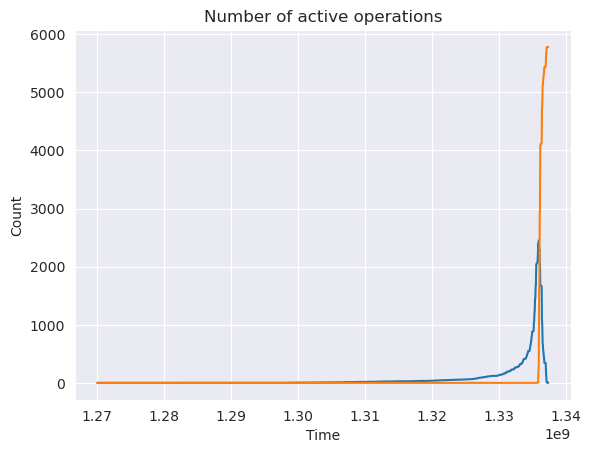

In [25]:
def get_split_indexes(df, case_id_name, start_date_name, train_size=float):
    print('Starting splitting procedure..')
    start_end_couple = list()
    for idx in df[case_id_name].unique():
        df_ = df[df[case_id_name] == idx].reset_index(drop=True)
        start_end_couple.append([idx, df_[start_date_name].values[0], df_[start_date_name].values[len(df_) - 1]])
    start_end_couple = pd.DataFrame(start_end_couple, columns=['idx', 'start', 'end'])
    print(f'The min max range is {start_end_couple.start.min()}, {start_end_couple.end.max()}')
    print(f'With length {start_end_couple.end.max() - start_end_couple.start.min()}')
    # Initialize pdf of active cases and cdf of closed cases
    times_dict_pdf = dict()
    times_dict_cdf = dict()
    split = int((start_end_couple.end.max() - start_end_couple.start.min()) / 10000)  # In order to get a 10000 dotted graph
    for time in range(int(start_end_couple.start.min()), int(start_end_couple.end.max()), split):
        times_dict_pdf[time] = 0
        times_dict_cdf[time] = 0
    for time in tqdm.tqdm(range(int(start_end_couple.start.min()), int(start_end_couple.end.max()), split)):
        for line in np.array(start_end_couple[['start', 'end']]):
            line = np.array(line)
            if (line[0] <= time) and (line[1] >= time):
                times_dict_pdf[time] += 1
    for time in tqdm.tqdm(range(int(start_end_couple.start.min()), int(start_end_couple.end.max()), split)):
        for line in np.array(start_end_couple[['start', 'end']]):
            line = np.array(line)
            if (line[1] <= time):  # Keep just k closes cases
                times_dict_cdf[time] += 1
    sns.set_style('darkgrid')
    plt.title('Number of active operations')
    plt.xlabel('Time')
    plt.ylabel('Count')

    times_pdf_df = pd.DataFrame( {"time": list(times_dict_pdf.keys()), "count": list(times_dict_pdf.values())} )
    times_cdf_df = pd.DataFrame( {"time": list(times_dict_cdf.keys()), "count": list(times_dict_cdf.values())} )

    sns.lineplot(data=times_pdf_df, x="time", y="count")
    sns.lineplot(data=times_cdf_df, x="time", y="count")
    plt.savefig('Active and completed cases distribution.png')
    times_dist = pd.DataFrame(columns=['times', 'pdf_active', 'cdf_closed'])
    times_dist['times'] = times_dict_pdf.keys()
    times_dist['pdf_active'] = times_dict_pdf.values()
    times_dist['cdf_closed'] = np.array(list(times_dict_cdf.values())) / (len(df[case_id_name].unique()))
    # Set threshold after 60 of closed activities (it'll be the train set)
    test_dim = times_dist[times_dist.cdf_closed > train_size].pdf_active.max()
    thrs = times_dist[times_dist.pdf_active == test_dim].times.values[0]
    train_idxs = start_end_couple[start_end_couple['end'] <= thrs]['idx'].values
    test_idxs = start_end_couple[start_end_couple['end'] >= thrs][start_end_couple['start'] <= thrs]['idx'].values

    with open(f'indexes/train_idx_{case_id_name}.pkl', 'wb') as file_handle:
        pickle.dump(train_idxs, file_handle)
    with open(f'indexes/test_idx_{case_id_name}.pkl', 'wb') as file_handle:
        pickle.dump(test_idxs, file_handle)
    print('Split done')
if KPI == "total_time":
    get_split_indexes(df, case_id_name, start_date_name, train_size=train_size)

In [29]:
if KPI == "total_time":
    with open(f'indexes/train_idx_{case_id_name}.pkl', 'rb') as file_handle:
        train_idxs = pickle.load(file_handle)
    with open(f'indexes/test_idx_{case_id_name}.pkl', 'rb') as file_handle:
        test_idxs = pickle.load(file_handle)

    total = len(train_idxs) + len(test_idxs)
    print(f"Percentage of train_idxs: { (len(train_idxs) / total):,}%, Number of train_idxs: {len(train_idxs):,}")
    print(f"Percentage of test_idxs: { len(test_idxs) / total:,}%, Number of test_idxs: {len(test_idxs):,}")

    df_train = df[df[case_id_name].isin(train_idxs)].copy()
    df_train = df_train.reset_index(drop=True)
    df_test = df[df[case_id_name].isin(test_idxs)].copy()
    df_test = df_test.reset_index(drop=True)

    df_train.to_csv( os.path.join(preprocessed_data_dir, "vinst_train.csv"), index=False)
    df_test.to_csv( os.path.join(preprocessed_data_dir, "vinst_test.csv"), index=False)

Percentage of train_idxs: 0.8085437564856451%, Number of train_idxs: 4,675
Percentage of test_idxs: 0.1914562435143549%, Number of test_idxs: 1,107


In [58]:
test_idxs

array(['1-467153946', '1-543979253', '1-565045794', ..., '1-740847124',
       '1-740847333', '1-740848036'], dtype=object)

### Save the Preprocessed dataset for later use

# Predict using CatBoost

In [113]:
# First we need to get all the categorical columns for the CatBoost Algorithm
categorical_features = df.iloc[:, 1:-1].select_dtypes(exclude=np.number).columns
df[categorical_features] = df[categorical_features].astype(str)
categorical_features = categorical_features.tolist()

In [55]:
X_train = df_train.iloc[:, 1: -1]
y_train = df_train.iloc[:, -1 ]

In [56]:
train_pool = Pool(X_train, y_train, cat_features=categorical_features)

In [24]:
params = {
    'depth': 10,
    'learning_rate': 0.01,
    'iterations': 3000,
    'early_stopping_rounds': 5,
    'thread_count': 4,
    'logging_level': 'Silent',
    'task_type': "CPU"  # "GPU" if int(os.environ["USE_GPU"]) else "CPU"
}

In [32]:
model = CatBoostRegressor(**params)
if use_saved_model:
    model.load_model(fname="catboost_model.cbm", format='cbm')
else:
    model.fit(train_pool)
    model.save_model(fname="catboost_model.cbm", format="cbm")

### Predict

In [33]:
X_train_pool = Pool(X_train, cat_features=categorical_features)
y_train_pred = model.predict(X_train_pool)


### Validate

In [34]:
# Mean Absolute Error
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred)}")

24373.989614527192

In [80]:
y_train_pred_series = pd.DataFrame(y_train_pred, columns=["Y_predictions"])
print(len(y_train_pred_series))
print(len(df_train))

31219
31219


In [81]:
# see the results
# # Should be a function
df_train_info = df_train[[case_id_name, "Status", activity_column_name, "time_from_first", "time_from_previous_et",
                    "time_remaining", target_column_name]].copy()
# Convert seconds to hours
df_train_info.loc[:, "time_remaining"] = round( df_train_info.loc[:, "time_remaining"] / (60 * 60), 2)
df_train_info[target_column_name] = df_train_info[target_column_name] / (60 * 60)
y_train_pred_series = round( y_train_pred_series / (60 * 60), 2)

df_results = pd.concat([df_train_info, y_train_pred_series], axis="columns")

In [82]:
df_results.to_csv("temp.csv", index=False)